# Check local solution

In this notebook, we want to verify the `LeafNode` object is computing an acceptable solution to the inhomogeneous Helmholtz equation. 

In [1]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
# I have to do this because I'm running the notebook in the checks/ directory
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:

from src.hps.interior_solution import (LeafNode, build_interior_dtn_map)
from src.utils import (differentiation_matrix_1d, 
                       chebyshev_points, 
                       points_to_2d_lst_of_points, 
                       get_incident_plane_waves)

### Set up geometric information about the local grid, as well as a simple scattering object

In [4]:
DOMAIN_MAX = 0.5
N_CHEB_PTS = 50
N_GAUSS_PTS = 50
UPPER_LEFT_X = -0.5
UPPER_LEFT_Y = 0.5


In [5]:
x = torch.linspace(-DOMAIN_MAX, DOMAIN_MAX, N_CHEB_PTS)
pts_lst = points_to_2d_lst_of_points(x)
radii = torch.linalg.norm(pts_lst, axis=1)

scattering_obj = 1e-04 * (torch.exp(-1 * radii))
obj_for_plt = scattering_obj.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS)

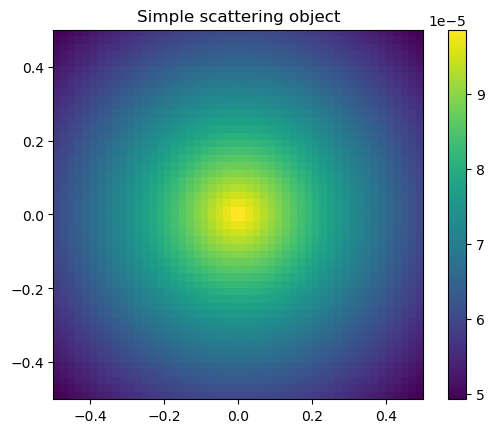

In [6]:
plt.imshow(obj_for_plt, extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
plt.colorbar()
plt.title('Simple scattering object')
plt.show()

## Set up LeafNode cell

In [7]:
omega_val = 2 * np.pi * 4
l = LeafNode(DOMAIN_MAX, 
             N_CHEB_PTS, 
             N_GAUSS_PTS, 
             UPPER_LEFT_X, 
             UPPER_LEFT_Y, 
             omega_val, 
             scattering_obj, 
             pts_lst)

norm_factor:  1


In [9]:
# Interpolate the solution to the regular grid
interp_obj = LinearNDInterpolator(l.cheby_quad_obj.points_lst.numpy(), u_scat_on_cheby_pts.numpy())

X, Y = torch.meshgrid(
    x, torch.flipud(x), indexing="ij"
)

# u_scat_on_regular_grid = interp_obj(X.numpy(), Y.numpy())


## Testing leaf node's A matrix

Things that I can do to test LeafNode: 
 - If $q(x) = 0$, then $Au_{in} = 0$. 
 - If $q(x) = q$, then $Av = 0$ for a plane wave $v$ with the same direction but different frequency (??? Is this true ???)
 



In [11]:
q_zero = torch.zeros_like(pts_lst[:, 0])
l_zero = LeafNode(DOMAIN_MAX, N_CHEB_PTS, N_GAUSS_PTS, UPPER_LEFT_X, UPPER_LEFT_Y, omega_val, q_zero, pts_lst)

A_zero = l_zero.A

u_in = get_incident_plane_waves(s, omega_val, l_zero.cheby_quad_obj.points_lst)
print(u_in.dtype)
print(A_zero.dtype)

Au_in = A_zero.to(torch.complex128) @ u_in
print(torch.linalg.norm(Au_in))

norm_factor:  1
torch.complex128
torch.float64
tensor(2.7040e-08, dtype=torch.float64)


In [12]:
print(pts_lst.shape)

torch.Size([2500, 2])


In [13]:
Au_in_reg = l.cheby_quad_obj.interp_from_2d_points(pts_lst, Au_in)
u_in_reg = l.cheby_quad_obj.interp_from_2d_points(pts_lst, u_in)

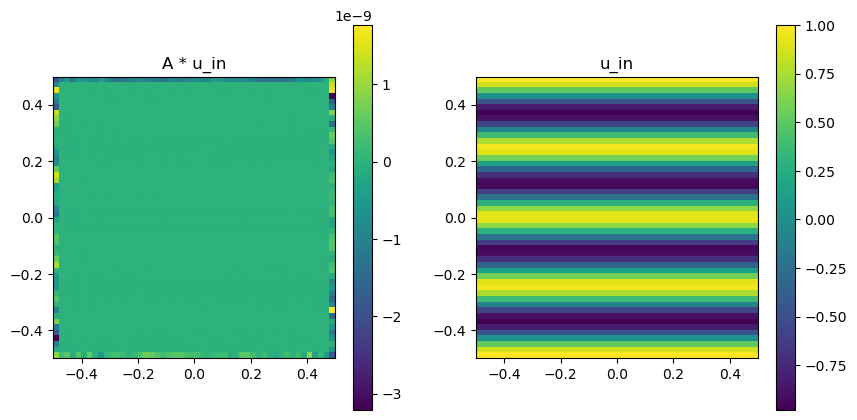

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im_0 = ax[0].imshow(Au_in_reg.numpy().real.reshape(N_CHEB_PTS, N_CHEB_PTS), 
                    extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
ax[0].set_title('A * u_in')
plt.colorbar(im_0, ax=ax[0])

im_1 = ax[1].imshow(u_in_reg.numpy().real.reshape(N_CHEB_PTS, N_CHEB_PTS), 
                    extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
ax[1].set_title('u_in')
plt.colorbar(im_1, ax=ax[1])

plt.show()


## Testing the leaf node's R matrix

The `R` matrix maps incoming impedance data to outgoing impedance data. 

Incoming impedance data is 
$$ f = u_{n} + i \eta u \rvert_{\delta \Omega} $$

and the outgoing impedance data is 

$$ g = u_{n} - i \eta u \rvert_{\delta \Omega} $$
So
$$ Rf = g$$


??? How do I test this ???

## Testing the T_int DtN Map

I can look at the SVD of T_int to make sure it is invertable.

In [4]:
DOMAIN_MAX = 0.5
N_CHEB_PTS = 50
N_GAUSS_PTS = 55
UPPER_LEFT_X = -0.5
UPPER_LEFT_Y = 0.5

x = torch.linspace(-DOMAIN_MAX, DOMAIN_MAX, N_CHEB_PTS)
pts_lst = points_to_2d_lst_of_points(x)
radii = torch.linalg.norm(pts_lst, axis=1)

scattering_obj = 1e-04 * (torch.exp(-1 * radii))

k = 2 * np.pi * 4
l = LeafNode(DOMAIN_MAX, 
             N_CHEB_PTS, 
             N_GAUSS_PTS, 
             UPPER_LEFT_X, 
             UPPER_LEFT_Y, 
             k, 
             scattering_obj, 
             pts_lst)

norm_factor:  1


In [5]:
R = l.get_R()

In [25]:
T_int = build_interior_dtn_map(l, k)

In [26]:
print(T_int.shape)

torch.Size([220, 220])


In [27]:
print(T_int.abs().min(), 
      T_int.abs().max())

tensor(3.4098) tensor(53938.2812)


In [31]:
u, s, v_t = torch.linalg.svd(T_int)
print(f"Condition number: {s[0] / s[-1]:.3e}")

Condition number: 8.114e+08


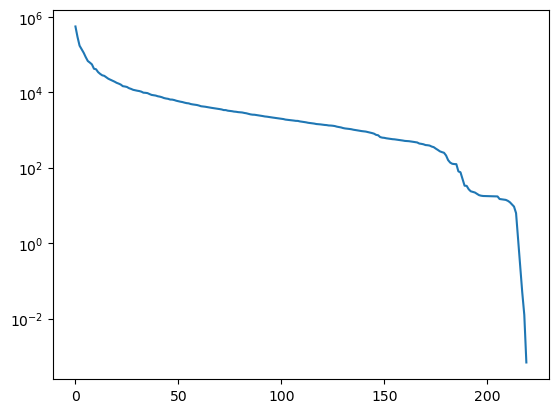

In [29]:
plt.plot(s)
plt.yscale('log')
plt.show()